In [1]:
import pandas as pd
import numpy as np
import os
import sys
import joblib
import mlflow
import tensorflow as tf
import shutil
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt
import seaborn as sns

current_path = Path.cwd()

if current_path.name == "Notebooks":
    os.chdir(current_path.parent)

project_root = Path.cwd()
data_path = project_root / "data" / "maternal_risk_processed.csv"
db_path = project_root / "mlflow.db"
mlruns_path = project_root / "mlruns"

mlflow.set_tracking_uri(f"sqlite:///mlflow.db")

experiment_name = "Maternal_Health_Project"

print(f"🔧 Configurando MLflow en raíz...")

try:
    mlflow.create_experiment(experiment_name)
    print(f"✅ Experimento creado exitosamente.")
except mlflow.exceptions.MlflowException:
    exp = mlflow.get_experiment_by_name(experiment_name)
    print(f"ℹ El experimento ya existe. ID: {exp.experiment_id}")
    print(f"  Ruta de artefactos actual: {exp.artifact_location}")

mlflow.set_experiment(experiment_name)

print("✓ Configuración completada")

🔧 Configurando MLflow en raíz...


2026/02/05 01:36:45 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/05 01:36:45 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/05 01:36:45 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/05 01:36:45 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/05 01:36:45 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/05 01:36:45 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/05 01:36:45 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/05 01:36:45 INFO mlflow.store.db.utils: Updating database tables
2026/02/05 01:36:45 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/05 01:36:45 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/05 01:36:45 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/02/05 01:3

✅ Experimento creado exitosamente.
✓ Configuración completada


In [2]:
# Load Data
if not data_path.exists():
    raise FileNotFoundError(f"File not found: {data_path}")

df = pd.read_csv(data_path)
X = df.drop(['RiskLevel', 'Risk_Num'], axis=1)
y = df['Risk_Num']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"✓ Data loaded and scaled. Train shape: {X_train.shape}")

✓ Data loaded and scaled. Train shape: (811, 6)


In [3]:
def create_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(3, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model(X_train.shape[1])
print("✓ Model initialized")

✓ Model initialized


In [4]:
# Training Config
params = {
    "epochs": 50,
    "batch_size": 16,
    "layers": [16, 8, 3],
    "dropout": 0.1
}

# Generate versioned name for Registry
timestamp = datetime.now().strftime("%d%m%y%H%M")
registered_model_name = f"model_v{timestamp}"

print(f"Starting run for: {registered_model_name}")

with mlflow.start_run(run_name="Base_Model_Training") as run:
    # 1. Log Params
    mlflow.log_params(params)
    
    # 2. Train
    history = model.fit(
        X_train, y_train,
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        validation_split=0.1,
        verbose=1
    )
    
    # 3. Metrics
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metrics({"test_accuracy": accuracy, "test_loss": loss})
    
    # 4. Signature
    predictions = model.predict(X_train[:5], verbose=0)
    signature = infer_signature(X_train, predictions)
    
    # 5. Log Scaler
    # Save to PROJECT ROOT temporarily, then upload
    tmp_scaler_path = project_root / "scaler.pkl"
    joblib.dump(scaler, tmp_scaler_path)
    mlflow.log_artifact(str(tmp_scaler_path))
    
    # 6. Log Model
    model_info = mlflow.tensorflow.log_model(
        model,
        artifact_path="model",
        signature=signature
    )
    
    # 7. Register Model in Registry
    print(f"Registering model as: {registered_model_name}...")
    mlflow.register_model(model_info.model_uri, registered_model_name)

print(f"\n✅ Training and Registration Complete.")
print(f"   Run ID: {run.info.run_id}")
print(f"   Registry Name: {registered_model_name}")

Starting run for: model_v0502260136
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4266 - loss: 1.0714 - val_accuracy: 0.5366 - val_loss: 1.0205
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5720 - loss: 1.0104 - val_accuracy: 0.5732 - val_loss: 0.9576
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5802 - loss: 0.9578 - val_accuracy: 0.5732 - val_loss: 0.8975
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5885 - loss: 0.9023 - val_accuracy: 0.5610 - val_loss: 0.8492
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5967 - loss: 0.8655 - val_accuracy: 0.5732 - val_loss: 0.8155
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6104 - loss: 0.8188 - val_accuracy: 0.6098 - val_loss: 0.7940
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6049 - loss: 0.8115 - val_accuracy: 0.6220 - val_loss: 0.7814
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6145 - loss: 0.803

2026/02/05 01:37:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/05 01:37:13 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/05 01:37:13 INFO mlflow.store.db.utils: Updating database tables
2026/02/05 01:37:13 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/05 01:37:13 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Registering model as: model_v0502260136...

✅ Training and Registration Complete.
   Run ID: 7c027ed16b92441eb756cbc8dcdd599f
   Registry Name: model_v0502260136


Successfully registered model 'model_v0502260136'.
Created version '1' of model 'model_v0502260136'.


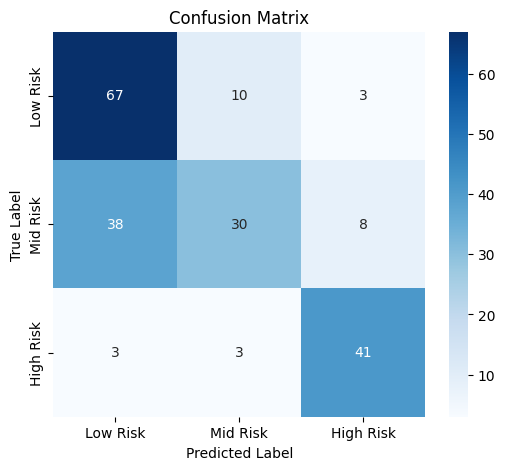


Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.62      0.84      0.71        80
    Mid Risk       0.70      0.39      0.50        76
   High Risk       0.79      0.87      0.83        47

    accuracy                           0.68       203
   macro avg       0.70      0.70      0.68       203
weighted avg       0.69      0.68      0.66       203



In [5]:
# Generate Confusion Matrix
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
risk_labels = ['Low Risk', 'Mid Risk', 'High Risk']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=risk_labels, yticklabels=risk_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=risk_labels))

## Conclusions

The model achieves an overall accuracy of 67%, performing notably well in detecting High Risk cases (F1-score 0.84 and Recall 0.89), which is crucial for prioritizing critical patients. However, there is a significant deficiency in classifying Mid Risk cases, where the model only identifies 33% of actual instances (Recall 0.33), suggesting that these intermediate patients are largely being misclassified as Low Risk (which shows high Recall but lower Precision).